# SALUD MURCIA

Lectura del conjunto de datos obtenido de la pagina de salud de Murcia 
https://www.murciasalud.es/pagina.php?id=458869
Recogidos desde el 08/03/2020 hasta el dia 25/03/2020

In [1]:
from pandas import read_csv
lectura = read_csv('../Datos_originales/casos_diarios_total_regional.csv', skiprows = 4, encoding='latin-1', sep = ';', index_col = 0, na_values = ['NaN', 'NaT'])
# Headers = columnas de mi conjunto de datos. Si no especificamos asume que son las de la primera fila leida
# Skiprows = n: con n = numero de filas que quiero saltar. Las cuatro primeras son texto -> las saltamos
# Encoding = 'latin-1': para que no de errores de codificacion de algunos caracteres 
# Sep = ';': delimitador que separa las columnas
# Index_col = 0: usar la primera columna (fechas) como filas del dataframe

Renombramos los nombres de algunas de las columnas para que queden mas compactos

In [2]:
datos = lectura.rename(columns={'Pruebas_PCR_Ag':'Pruebas_PCR_Ag',
                                'Casos_incidentes_PCR/Ag+':'Incidentes_PCR_Ag',
                                'Hospitalizados': 'H',
                                'Hospitaliz_UCI':'H_UCI',
                                'Asintomatico_hombre_<45años': 'Asint_H_<45',
                                'Asintomatico_hombre_45a64años': 'Asint_H_45a64',
                                'Asintomatico_hombre_+65años': 'Asint_H_+65',
                                'Sintomatico_hombre_<45años': 'Sint_H_<45',
                                'Sintomatico_hombre_45a64años': 'Sint_H_45a64',
                                'Sintomatico_hombre_+65años': 'Sint_H_+65',
                                'Asintomatico_mujer_<45años': 'Asint_M_<45',
                                'Asintomatico_mujer_45a64años': 'Asint_M_45a64',
                                'Asintomatico_mujer_+65años': 'Asint_M_+65',
                                'Sintomatico_mujer_<45años': 'Sint_M_<45',
                                'Sintomatico_mujer_45a64años': 'Sint_M_45a64',
                                'Sintomatico_mujer_+65años': 'Sint_M_+65'})

In [3]:
import pandas as pd
df = pd.DataFrame(datos)

In [4]:
df.head(5)

,Pruebas_PCR_Ag,Incidentes_PCR_Ag,H,H_UCI,Defunciones,Asint_H_<45,Asint_H_45a64,Asint_H_+65,Sint_H_<45,Sint_H_45a64,Sint_H_+65,Asint_M_<45,Asint_M_45a64,Asint_M_+65,Sint_M_<45,Sint_M_45a64,Sint_M_+65
Fecha,,,,,,,,,,,,,,,,,
08/03/2020,130.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
09/03/2020,21.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
10/03/2020,39.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0
11/03/2020,116.0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,4.0,1.0,1.0
12/03/2020,136.0,9.0,4.0,1.0,0.0,3.0,1.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0


Con la siguiente función eliminamos todos aquellos valores que se almacenan o completan como NaN

In [4]:
df.dropna(axis = 0, inplace = True)

A continuación vamos a coger cada una de las series y para cada una de ellas:
-Eliminación de datos autocompletados de fechas posteriores a la actual
-Visualización de las mismas

## Positivos

In [6]:
df_positivos = df['Incidentes_PCR_Ag']
print(df_positivos.head(5))

Fecha
08/03/2020     1.0
09/03/2020     3.0
10/03/2020     6.0
11/03/2020    12.0
12/03/2020     9.0
Name: Incidentes_PCR_Ag, dtype: float64


In [6]:
df_positivos.size

495

Fijandonos en las columnas del archivo .csv vemos que hay un total de 382 filas de datos (dias)
Como el tamaño de df_positivos es 495 > 382, podemos sospechar que existen datos de mas
Mostramos las 113 ultimas filas para ver que en efecto existen valores NaN no definidos

In [7]:
df_positivos.tail(113)

Fecha
25/03/2021    88.0
NaN            NaN
NaN            NaN
NaN            NaN
NaN            NaN
              ... 
NaN            NaN
NaN            NaN
NaN            NaN
NaN            NaN
NaN            NaN
Name: Incidentes_PCR_Ag, Length: 113, dtype: float64

Como podemos observar, hay muchas columnas que tienen datos desconocidos (identificados con NaN)
https://stackabuse.com/python-how-to-handle-missing-dataframe-values-in-pandas/
En este enlace vemos como podemos eliminar las filas cuyos valores son NaN -> mediante la funcion dropna
De esta forma los datos ya se visualizaran solo en las fechas correctas, es decir, las puestas en el .csv

In [9]:
df_positivos.dropna(axis = 0, inplace = True)

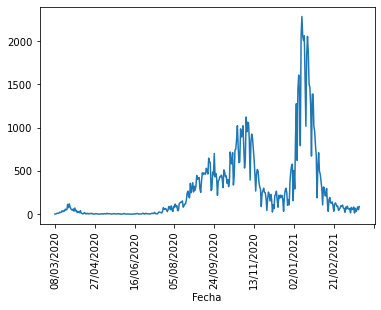

In [7]:
# Visualización de los datos con un plot simple
from matplotlib import pyplot
df_positivos.plot()
# Rotamos 45º las fechas para que se vean correctamente
pyplot.xticks(rotation=90)
pyplot.show()

Con el siguiente gráfico podemos hacer una primera aproximación sobre la presencia del virus
en la Región de Murcia. A simple vista, la pandemia parece haber sido bien controlada, puesto que
la nube de puntos más densa de encuentra entre los 0 y 500 casos

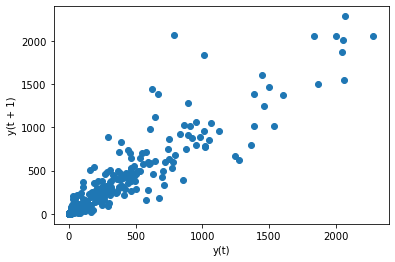

In [8]:
from pandas.plotting import lag_plot
lag_plot(df_positivos)
pyplot.show()

## Pruebas PCR y Ag

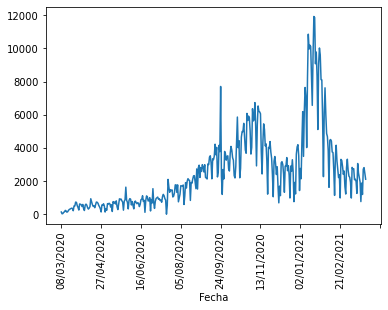

In [10]:
df_pruebas = df['Pruebas_PCR_Ag']
df_pruebas.plot()
pyplot.xticks(rotation=90)
pyplot.show()

## Hospitalizaciones

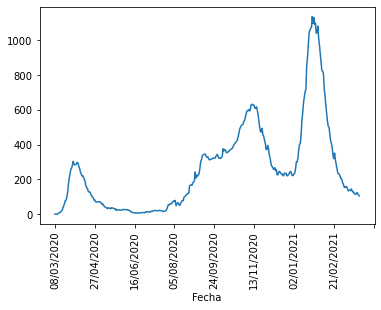

In [11]:
df_hospitalizados = df['H']
df_hospitalizados.plot()
pyplot.xticks(rotation=90)
pyplot.show()

## Hospitalizados en UCI

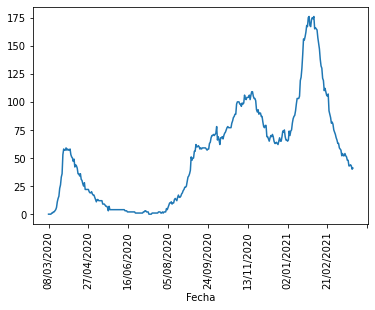

In [12]:
df_UCI = df['H_UCI']
df_UCI.plot()
pyplot.xticks(rotation=90)
pyplot.show()

## Defunciones

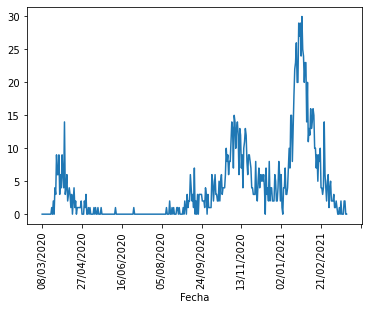

In [13]:
df_defunciones = df['Defunciones']
df_defunciones.plot()
pyplot.xticks(rotation=90)
pyplot.show()

A continuación se realiza un bucle en el que se visualizan los datos de todas las series del dataframe

Serie:  Pruebas_PCR_Ag


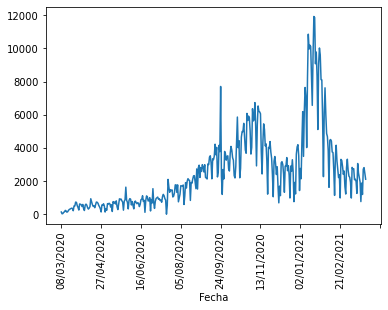

Serie:  Incidentes_PCR_Ag


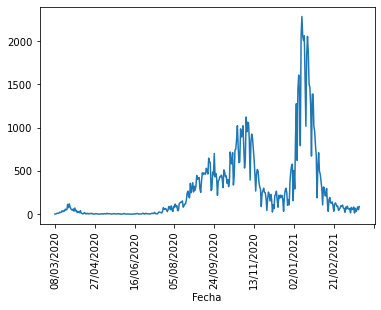

Serie:  H


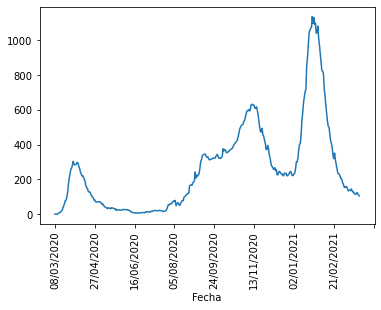

Serie:  H_UCI


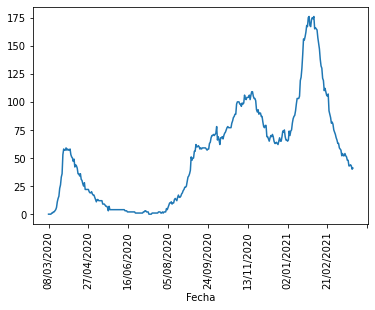

Serie:  Defunciones


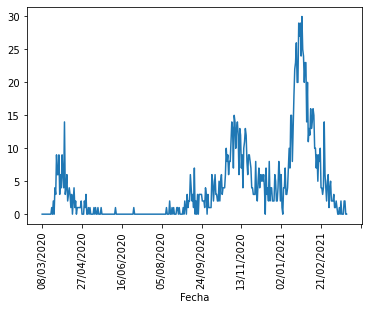

Serie:  Asint_H_<45


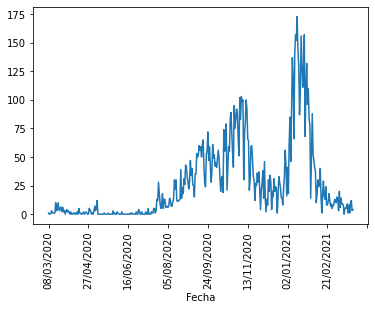

Serie:  Asint_H_45a64


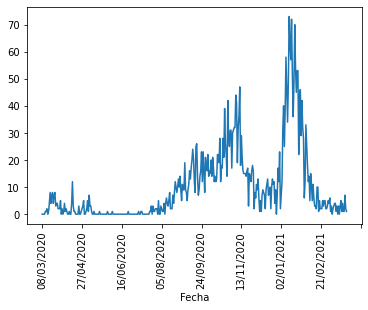

Serie:  Asint_H_+65


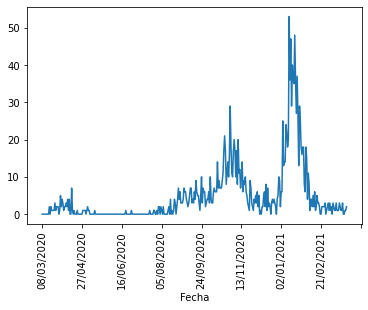

Serie:  Sint_H_<45


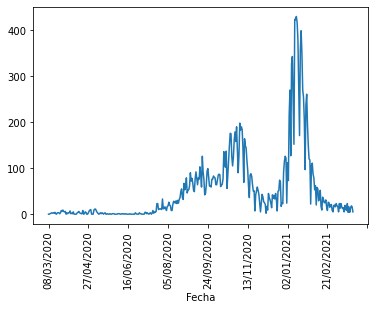

Serie:  Sint_H_45a64


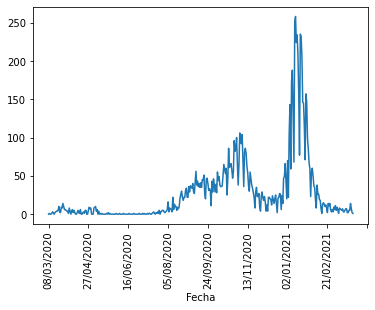

Serie:  Sint_H_+65


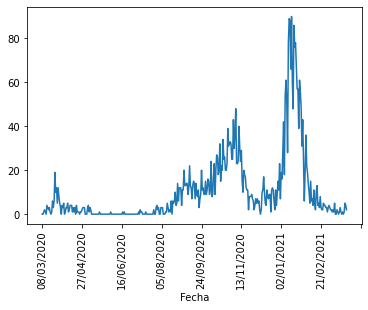

Serie:  Asint_M_<45


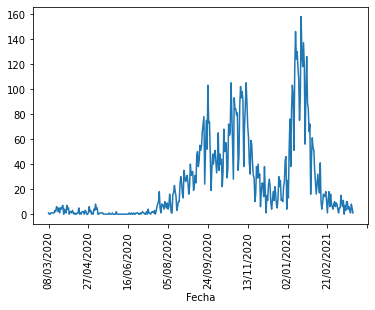

Serie:  Asint_M_45a64


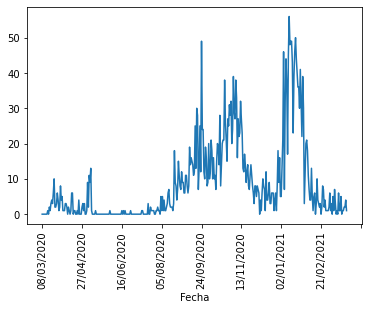

Serie:  Asint_M_+65


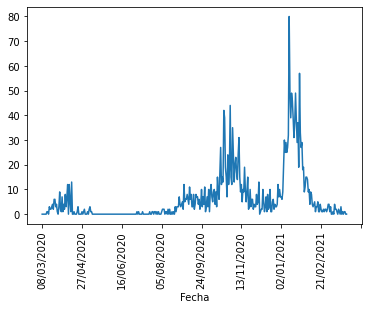

Serie:  Sint_M_<45


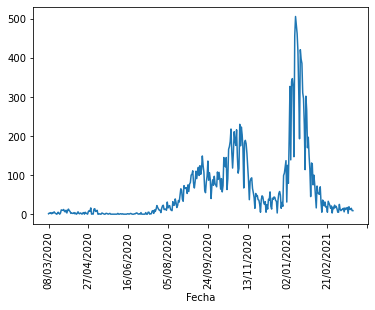

Serie:  Sint_M_45a64


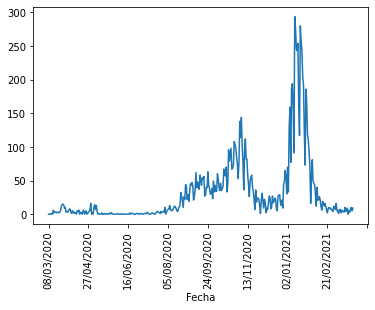

Serie:  Sint_M_+65


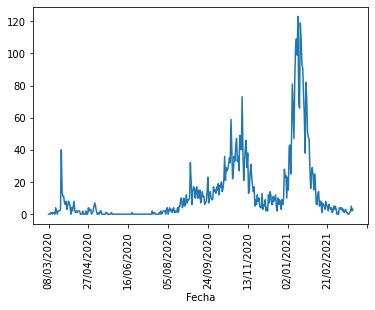

In [5]:
from matplotlib import pyplot
for c in df.columns:
    dfc = df[c]
    dfc.plot()
    print('Serie: ', c)
    pyplot.xticks(rotation=90)
    pyplot.show()

Las gráficas tienen mucha similitud entre ellas, lo que es bastante lógico.
El aumento/disminución del número de casos positivos se ve directamente relacionado con 
el aumento de hospitalizaciones, defunciones, asintomáticos, sintomáticos,...
En la siguiente tabla se muestra una matriz de correlación numérica y posteriormente de forma
gráfica para ayudarnos en la comprensión

In [6]:
df.corr()

,Pruebas_PCR_Ag,Incidentes_PCR_Ag,H,H_UCI,Defunciones,Asint_H_<45,Asint_H_45a64,Asint_H_+65,Sint_H_<45,Sint_H_45a64,Sint_H_+65,Asint_M_<45,Asint_M_45a64,Asint_M_+65,Sint_M_<45,Sint_M_45a64,Sint_M_+65
Pruebas_PCR_Ag,1.000000,0.924814,0.811592,0.734834,0.718329,0.933566,0.911111,0.867579,0.903061,0.892985,0.894980,0.921794,0.892010,0.824545,0.901545,0.896624,0.885204
Incidentes_PCR_Ag,0.924814,1.000000,0.696973,0.586305,0.601761,0.965496,0.964222,0.925786,0.990621,0.983499,0.968002,0.948945,0.935251,0.893010,0.992726,0.985723,0.959587
H,0.811592,0.696973,1.000000,0.944594,0.909462,0.739986,0.723352,0.698537,0.649055,0.654464,0.707222,0.742615,0.709185,0.685277,0.654741,0.664828,0.697528
H_UCI,0.734834,0.586305,0.944594,1.000000,0.845461,0.632167,0.617913,0.583016,0.548878,0.547027,0.588978,0.629459,0.597467,0.576001,0.549198,0.552182,0.577620
Defunciones,0.718329,0.601761,0.909462,0.845461,1.000000,0.633725,0.616070,0.632963,0.558880,0.576505,0.636659,0.622331,0.594146,0.613898,0.558010,0.594175,0.636567
Asint_H_<45,0.933566,0.965496,0.739986,0.632167,0.633725,1.000000,0.958641,0.893128,0.942459,0.924098,0.917391,0.969578,0.935279,0.851640,0.946899,0.926556,0.907964
Asint_H_45a64,0.911111,0.964222,0.723352,0.617913,0.616070,0.958641,1.000000,0.906274,0.945410,0.934062,0.937380,0.944370,0.926839,0.878923,0.945799,0.933921,0.930376
Asint_H_+65,0.867579,0.925786,0.698537,0.583016,0.632963,0.893128,0.906274,1.000000,0.912942,0.910753,0.913497,0.867692,0.858492,0.906688,0.909584,0.914918,0.928057
Sint_H_<45,0.903061,0.990621,0.649055,0.548878,0.558880,0.942459,0.945410,0.912942,1.000000,0.986354,0.958582,0.916031,0.906972,0.873665,0.990678,0.984552,0.948689
Sint_H_45a64,0.892985,0.983499,0.654464,0.547027,0.576505,0.924098,0.934062,0.910753,0.986354,1.000000,0.963612,0.898964,0.895694,0.870560,0.982993,0.989007,0.952831


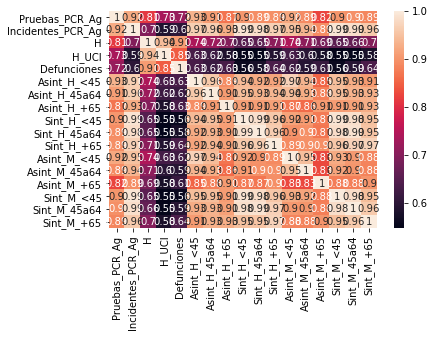

In [12]:
matriz_corr = df.corr()
import seaborn as sn
import matplotlib.pyplot as plt
sn.heatmap(matriz_corr, annot=True)
plt.show()

## Sumando asintomáticos
En esta sección vamos a sumar a todos los asintomáticos (por fecha) y añadirlos en una nueva serie
del dataframe a la que llamaré "Asintomaticos"

In [7]:
df['Asintomaticos'] = df['Asint_H_<45'] + df['Asint_H_45a64'] + df['Asint_H_+65']

A continuación lo que hacemos es guardarla en un archivo de extensión .csv 

In [10]:
df.to_csv(path_or_buf = '../Datos_preprocesados./datos_suma_asintomaticos.csv')